In [46]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import tensorflow as tf  
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir dataset

In [4]:
!cp "drive/My Drive/Data rn" dataset/ -r

In [114]:
classes = ["Tomatoes", "aubergines", "betterave",  "carottes", "concombre", "courgettes", 
           "navet", "oignon", "patates", "poivron"
           ]

In [115]:
len(classes)

10

In [111]:
!rm -rf "/content/dataset/Data rn/en plus" 

In [112]:
!rm -rf "/content/dataset/Data rn/feunouil"

In [113]:
!rm -rf "/content/dataset/Data rn/artichaut"

In [125]:
!rm -rf "/content/splitted-dataset"

In [126]:
!ls

dataset  drive	model.h5  sample_data


In [127]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [128]:
import splitfolders # or import splitfolders
input_folder = "/content/dataset/Data rn"
output = "splitted-dataset" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .2, .1))

Copying files: 771 files [00:10, 75.90 files/s]


In [130]:
dataset_path = "splitted-dataset"

for class_name in classes:
  for folder in ["train", "test", "val"]:
    dir_path= os.path.join(dataset_path, folder, class_name)
    print(class_name, folder, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Tomatoes train 54
Tomatoes test 9
Tomatoes val 15
aubergines train 47
aubergines test 8
aubergines val 13
betterave train 56
betterave test 8
betterave val 16
carottes train 67
carottes test 11
carottes val 19
concombre train 53
concombre test 8
concombre val 15
courgettes train 37
courgettes test 6
courgettes val 10
navet train 57
navet test 9
navet val 16
oignon train 37
oignon test 7
oignon val 10
patates train 64
patates test 10
patates val 18
poivron train 63
poivron test 10
poivron val 18


## Image generation

In [131]:
train_image_generator=ImageDataGenerator(rescale=1./255,vertical_flip='true',
                                         zoom_range=0.2,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         fill_mode='nearest'                                         
                                         )
valid_image_generator=ImageDataGenerator(rescale=1./255)

In [132]:
BATCH_SIZE=16
IMG_SHAPE=224

In [133]:
train_data_gen=train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         directory=os.path.join(dataset_path, "train"),
                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                                         shuffle='True',
                                                         class_mode='categorical')
valid_data_gen=valid_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         directory=os.path.join(dataset_path, "val"),
                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                                         class_mode='categorical')

Found 535 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


In [134]:
num_train = 535
num_valid = 150

In [135]:
sample_training_images, _=next(train_data_gen)

In [136]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

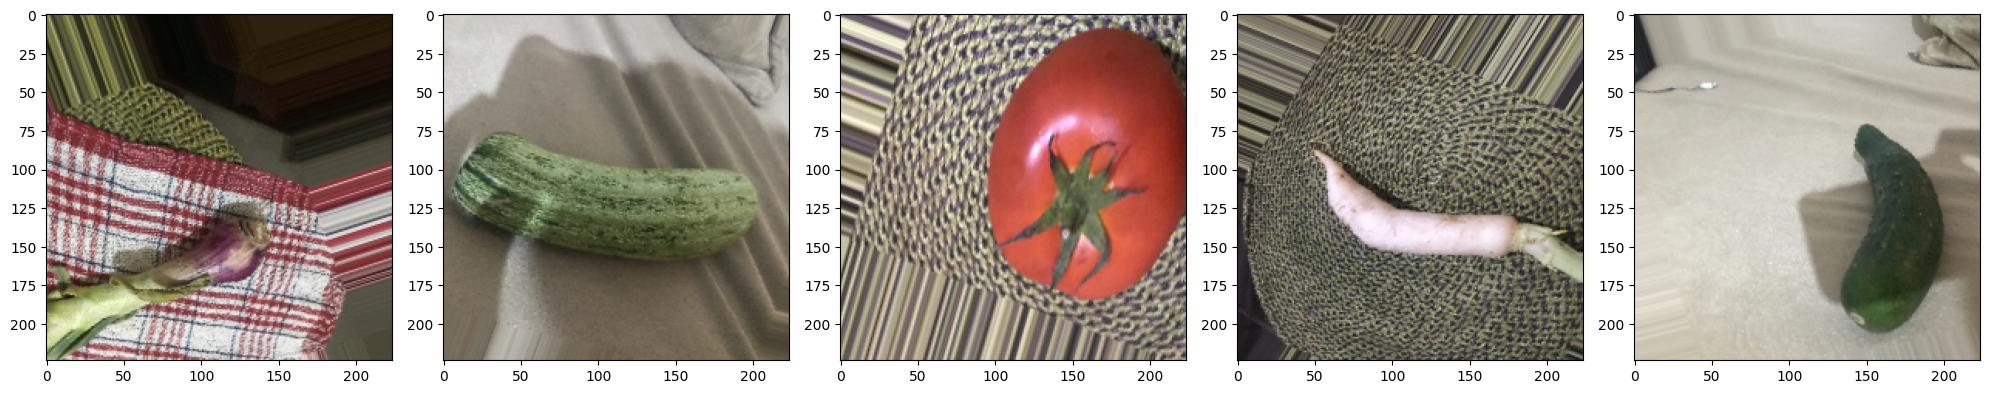

In [137]:
plotImages(sample_training_images[5:10])

# Model

# CNN

In [144]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224,224, 3)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [145]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 26, 26, 256)     

In [149]:

from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001,beta_1=0.9,beta_2 = 0.999, epsilon=1e-8)

In [150]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"], )

In [151]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model1.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [152]:
model.fit(train_data_gen,
          steps_per_epoch=len(train_data_gen),
          validation_data=valid_data_gen,
          validation_steps=len(valid_data_gen),
          epochs=20,
          batch_size=BATCH_SIZE, 
          verbose = 2,
          callbacks=[es, mc]
)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to ./model1.h5
34/34 - 382s - loss: 2.1966 - accuracy: 0.1794 - val_loss: 1.9300 - val_accuracy: 0.2667 - 382s/epoch - 11s/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.26667 to 0.40667, saving model to ./model1.h5
34/34 - 399s - loss: 1.8656 - accuracy: 0.3103 - val_loss: 1.5525 - val_accuracy: 0.4067 - 399s/epoch - 12s/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.40667 to 0.52667, saving model to ./model1.h5
34/34 - 403s - loss: 1.5889 - accuracy: 0.4318 - val_loss: 1.3382 - val_accuracy: 0.5267 - 403s/epoch - 12s/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.52667
34/34 - 408s - loss: 1.4203 - accuracy: 0.4935 - val_loss: 1.6325 - val_accuracy: 0.3867 - 408s/epoch - 12s/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.52667 to 0.56000, saving model to ./model1.h5
34/34 - 408s - loss: 1.3511 - accuracy: 0.4879 - val_loss: 1.1813 - val_accuracy: 0.5600 - 408s/epoch - 

In [153]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model2.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(train_data_gen,
          steps_per_epoch=len(train_data_gen),
          validation_data=valid_data_gen,
          validation_steps=len(valid_data_gen),
          epochs=20,
          batch_size=BATCH_SIZE, 
          verbose = 2,
          callbacks=[es, mc]
)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to ./model2.h5
34/34 - 415s - loss: 0.3168 - accuracy: 0.8953 - val_loss: 0.2766 - val_accuracy: 0.9333 - 415s/epoch - 12s/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.93333
34/34 - 400s - loss: 0.3620 - accuracy: 0.8972 - val_loss: 0.4097 - val_accuracy: 0.8933 - 400s/epoch - 12s/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.93333
34/34 - 403s - loss: 0.4910 - accuracy: 0.8374 - val_loss: 0.5077 - val_accuracy: 0.8267 - 403s/epoch - 12s/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.93333
34/34 - 361s - loss: 0.4470 - accuracy: 0.8523 - val_loss: 0.2564 - val_accuracy: 0.9200 - 361s/epoch - 11s/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.93333
34/34 - 392s - loss: 0.3028 - accuracy: 0.8991 - val_loss: 0.3055 - val_accuracy: 0.9267 - 392s/epoch - 12s/step
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.93333
34/34 - 386s - loss: 0.2443

# ViT

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


##### generate patches 
class generate_patch(layers.Layer):
  def __init__(self, patch_size):
    super(generate_patch, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images, 
                                       sizes=[1, self.patch_size, self.patch_size, 1], 
                                       strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims]) #here shape is (batch_size, num_patches, patch_h*patch_w*c) 
    return patches

#############
# visualize
#############
from itertools import islice, count

train_iter_7im, train_iter_7label = next(islice(training_data, 7, None)) # access the 7th element from the iterator



train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy() 

generate_patch_layer = generate_patch(patch_size=patch_size)
patches = generate_patch_layer(train_iter_7im)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)



def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')    

        


render_image_and_patches(train_iter_7im, patches)

In [ ]:
class PatchEncode_Embed(layers.Layer):
  '''
  2 steps happen here
  1. flatten the patches 
  2. Map to dim D; patch embeddings  
  '''
  def __init__(self, num_patches, projection_dim):
    super(PatchEncode_Embed, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim) # activation = linear
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim)
    
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded
     


In [ ]:
class generate_patch_conv(layers.Layer):
  '''
  this is an example to generate conv patches comparable with the image patches
  generated using tf extract image patches. This wasn't the original implementation, specially 
  the number of filters in the conv layer has nothing to do with patch size. It must be same as
  hidden dim (query/key dim) in relation to multi-head attention layer.       
  '''
  def __init__(self, patch_size):
    super(generate_patch_conv, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = layers.Conv2D(self.patch_size*self.patch_size*3, self.patch_size, self.patch_size, padding='valid')(images)

    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches  

class generate_patch_conv_orgPaper(layers.Layer):
  '''
  original implementation, 
  hidden size = query/key dim in multi head attention layer later. 
  '''
  def __init__(self, patch_size, hidden_size):
    super(generate_patch_conv_orgPaper, self).__init__()
    self.patch_size = patch_size
    self.hidden_size = hidden_size

  def call(self, images):
    patches = layers.Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding='valid', name='Embedding')(images) 
    # kernels and strides = patch size
    # the weights of the convolutional layer will be learned. 
    rows_axis, cols_axis = (1, 2) # channels last images
    #if channels_last:
      #rows_axis, cols_axis = (2, 3) # for channels last
      # x = tf.transpose(patches, perm=[0, 2, 3, 1]) # do this for channels_first
    seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
    return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
  patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
  row_axis, col_axis = (1, 2) # channels last images
  seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
  x = tf.reshape(patches, [-1, seq_len, hidden_size])
  return x




train_iter_7im = tf.cast(train_iter_7im, dtype=tf.float16)
generate_patch_conv_layer = generate_patch_conv(patch_size=patch_size)
patches_conv = generate_patch_conv_layer(train_iter_7im)


print ('patch per image and patches shape: ', patches_conv.shape[1], '\n', patches_conv.shape)    

generate_patch_conv_orgPaper_layer = generate_patch_conv_orgPaper(patch_size=patch_size, hidden_size=64)
patches_conv_org = generate_patch_conv_orgPaper_layer(train_iter_7im)

hidden_size=64
patches_conv_org_f = generate_patch_conv_orgPaper_f(patch_size, hidden_size, train_iter_7im)

print ('patch per image and patches shape: ', patches_conv_org.shape[1], '\n', patches_conv_org.shape)
print ('patch per image and patches shape: ', patches_conv_org_f.shape[1], '\n', patches_conv_org_f.shape)

In [ ]:


def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')

render_image_and_patches(train_iter_7im, patches_conv)        
     


In [ ]:
class AddPositionEmbs(layers.Layer):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, posemb_init=None, **kwargs):
    super().__init__(**kwargs)
    self.posemb_init = posemb_init
    #posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input') # used in original code

  def build(self, inputs_shape):
    pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
    self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

  def call(self, inputs, inputs_positions=None):
    # inputs.shape is (batch_size, seq_len, emb_dim).
    pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

    return inputs + pos_embedding


pos_embed_layer = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))
embedded_inp = pos_embed_layer(patches_conv_org)

print ('embedded input shape: ', embedded_inp.shape)

In [ ]:
def mlp_block_f(mlp_dim, inputs):
  x = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
  x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
  x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
  x = layers.Dropout(rate=0.1)(x)
  return x

# class Encoder1Dblock(layers.Layer):
#   def __init__(self, num_heads, mlp_dim):
#     super(Encoder1Dblock, self).__init__()
#     self.num_heads = num_heads # number of heads in multi-head block
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.LayerNormalization(dtype=self.dtype)(inputs)
#     x = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
#     x = layers.Add()([x, inputs]) # 1st residual part 
    
    # #### mlp block 
    # y = layers.LayerNormalization(dtype=self.dtype)(x)
    # y = mlp_block(mlp_dim=self.mlp_dim)(y)
    # y_1 = layers.Add()([y, x]) #2nd residual part 
    # return y_1


def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
  x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
  x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
  x = layers.Add()([x, inputs]) # 1st residual part 
  
  y = layers.LayerNormalization(dtype=x.dtype)(x)
  y = mlp_block_f(mlp_dim, y)
  y_1 = layers.Add()([y, x]) #2nd residual part 
  return y_1


#########################################
# test with the embeddings as input
#########################################
# Encoder1Dblock_layer = Encoder1Dblock(num_heads=4, mlp_dim=32)
# Encoder1Dblock_layer_out = Encoder1Dblock_layer(embedded_inp)
Encoder1Dblock_layer_out_f = Encoder1Dblock_f(4, 32, embedded_inp)

# print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out.shape)
print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out_f.shape)

In [ ]:
def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
  x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
  x = layers.Dropout(rate=0.2)(x)
  for _ in range(num_layers):
    x = Encoder1Dblock_f(num_heads, mlp_dim, x)

  encoded = layers.LayerNormalization(name='encoder_norm')(x)
  return encoded




######################################
# hyperparameter section 
###################################### 
transformer_layers = 6
patch_size = 4
hidden_size = 64
num_heads = 4
mlp_dim = 128

######################################




def build_ViT():
  inputs = layers.Input(shape=train_im.shape[1:])
  # rescaling (normalizing pixel val between 0 and 1)
  rescale = rescale_layer(inputs)
  # augmentation 
  # augmented = data_augmentation(rescale)
  # generate patches with conv layer
  patches = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale)

  ######################################
  # ready for the transformer blocks
  ######################################
  encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches)  

  #####################################
  #  final part (mlp to classification)
  #####################################
  #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
  im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

  logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

  final_model = tf.keras.Model(inputs = inputs, outputs = logits)
  return final_model



ViT_model = build_ViT()
ViT_model.summary()

In [ ]:
tf.keras.utils.plot_model(ViT_model, rankdir='TB')

In [ ]:
ViT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5 acc')]) 


# ViT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), 
#                   loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
#                   metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5 acc'), 
#                            tf.keras.metrics.Precision(name='pre'), 
#                            tf.keras.metrics.Recall(name='rec')])


#tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")],) 
# from logits = True, because Dense layer has linear activation


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5, verbose=1)

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=10, verbose=0, 
                                      mode="auto", baseline=None,restore_best_weights=False)


ViT_Train = ViT_model.fit(train_data_gen, 
                        epochs = 120, 
                        validation_data=valid_data_gen, callbacks=[reduce_lr, es, mc], verbose=2)